# Tensorflow Callbacks

Callbacks helps in preventing overfitting, to visualize training process, save checkpoints, debug the code etc..




Callbacks can be passed to keras methods such as fit, evaluate, and predict in order to hook into the various stages of the model training and inference lifecycle.

In [1]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_datasets as tfdt
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import datetime

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the dataset for our experiment

In [2]:
data, info = tfdt.load('mnist', split = 'train[80%:]', with_info = True, as_supervised = True)

In [3]:
tfdt.as_dataframe(data.take(4),info)

2024-06-23 11:01:39.498650: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-23 11:01:39.498752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,image,label
0,,8
1,,5
2,,3
3,,9


2024-06-23 11:01:39.713370: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-23 11:01:39.720992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


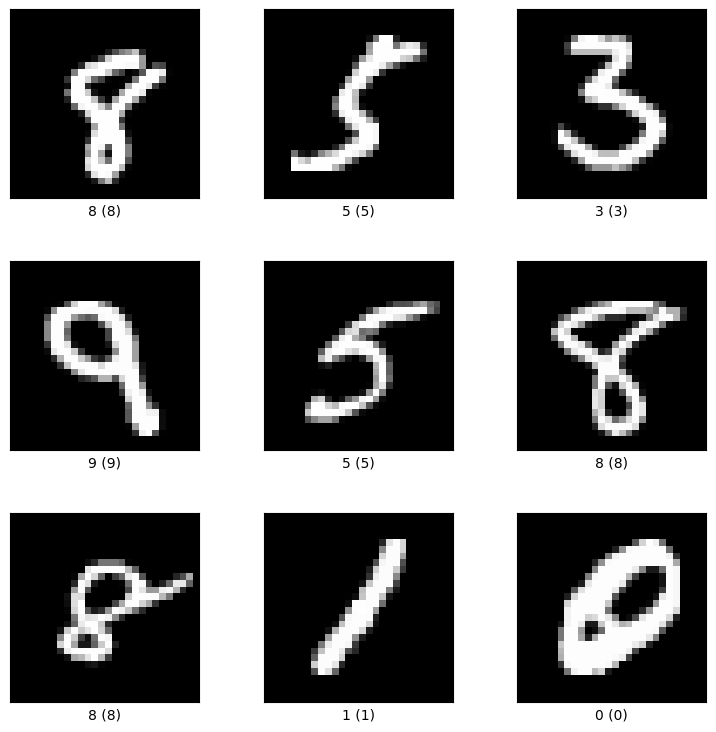

In [4]:
fig = tfdt.show_examples(data, info)

In [5]:
print(f"Number of labels: {info.features['label'].num_classes}")
print(f"Label names: {info.features['label'].names}")
print(f"Image shape: {info.features['image'].shape}")

print(f"The index 7 corresponds to digit {info.features['label'].int2str(7)}")
print(f"The digit 9 corresponds to index {info.features['label'].str2int('9')}")

Number of labels: 10
Label names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Image shape: (28, 28, 1)
The index 7 corresponds to digit 7
The digit 9 corresponds to index 9


In [6]:
# Set the variables

IMAGE_SIZE = (28,28)
BATCH_SIZE = 32
EPOCHS = 5

# Divide the dataset into training and test
training_split = data.take(int(len(data)*0.8))
testing_split = data.skip(int(len(data)*0.8))

print(f"Training images : {len(training_split)}")
print(f"Testing images : {len(testing_split)}")

Training images : 9600
Testing images : 2400


In [7]:
# Since we have the images with use in dataframe, we will be manually rescaling them and dividing them to batches.

rescale_layer = tf.keras.layers.Rescaling(1/255.)

#Building training pipeline
#1. scale the dataset
train_data = training_split.map(lambda x,y: (rescale_layer(x, training=True), y))
#2. Cache the dataset for better performance
train_data = train_data.cache()
#3. Suffle the data
train_data = train_data.shuffle(len(train_data))
#4. Divide the data into batches
train_data = train_data.batch(batch_size = 32)
#5. End with prefetch for better performance
train_data = train_data.prefetch(buffer_size = tf.data.AUTOTUNE) #AUTOTUNE helps in dynamic tunning based on available resources.


# Similarly building testing pipeline
test_data = testing_split.map(lambda x,y: (rescale_layer(x, training=True), y))
test_data = test_data.cache()
test_data = test_data.batch(batch_size = 32)
test_data = test_data.prefetch(buffer_size = tf.data.AUTOTUNE)




## tf.keras.callbacks.ModelCheckpoint 

Callback to save the Keras model or model weights at some frequency.

From Docs:
ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint


In [19]:
def create_checkpoint_callback(experiment, monitor="val_loss", patience = 100):
    mc_callback_directory = './callback_examples/model_checkpoint/' + experiment + '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+ '.weights.h5'
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = mc_callback_directory,
        save_weights_only = True,
        monitor=monitor,
        mode='max')
    return checkpoint_callback

## tf.keras.callbacks.EarlyStopping

Callback that will help stop the model from further learning when specific conditions are met.

From Docs: A model.fit() training loop will check at end of every epoch whether the loss is no longer decreasing, considering the min_delta and patience if applicable. Once it's found no longer decreasing, model.stop_training is marked True and the training terminates.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [9]:
def create_earlystopping_callback(metric = "val_loss", patience = 10):
    """
    Creates the Early stopping callback for the specified metrics
    :param metric: It can be "val_loss" or "val_accuracy"
    :param patience: Number of epochs with no improvement after which training will be stopped
    :return: Callbacks
    """
    return tf.keras.callbacks.EarlyStopping(monitor = metric,
                                            patience = patience,
                                            restore_best_weights=True)

## tf.keras.callbacks.LearningRateScheduler

Callback that will help change the learning rate.

From Docs: At the beginning of every epoch, this callback gets the updated learning rate value from schedule function provided at __init__, with the current epoch and current learning rate, and applies the updated learning rate on the optimizer.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler

In [10]:
# Scheduler
def scheduler_1(epoch, lr):
    if epoch <10:
        return lr
    else:
        return lr * math.exp(-0.1)

def create_learningratescheduler():
    return tf.keras.callbacks.LearningRateScheduler(scheduler_1,
                                           verbose = 0)

## tf.keras.callbacks.Tensorboard

Enable visualizations for TensorBoard.

From docs: TensorBoard is a visualization tool provided with TensorFlow. A TensorFlow installation is required to use this callback.

This callback logs events for TensorBoard, including:
* Metrics summary plots
* Training graph visualization
* Weight histograms
* Sampled profiling
  
When used in model.evaluate() or regular validation in addition to epoch summaries, there will be a summary that records evaluation metrics vs model.optimizer.iterations written. The metric names will be prepended with evaluation, with model.optimizer.iterations being the step in the visualized TensorBoard.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

In [17]:
def create_tensorboard(filepath, exp_name):
    """
    Creates Tensor Board in the specified Path
    :param filepath: To create the logs
    :param exp_name: experiment name
    :return: Callback
    """
    log_dir =  filepath + "/" + exp_name + "_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print(f"Saving tensor Board Logs in {log_dir}")
    return tf.keras.callbacks.TensorBoard(log_dir=log_dir)

## Trying the Callbacks on the model

In [22]:
# Create a model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10, (3,3), activation = "relu"),
    tf.keras.layers.Conv2D(10, (3,3), activation = "relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, (3,3), activation = "relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, (3,3), activation = "relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = "softmax")
])

In [23]:
model_1.compile(loss =tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])                

In [24]:
history_1 = model_1.fit(train_data,
                        epochs = 100,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = int(0.25 * len(test_data)),
                        callbacks = [create_tensorboard(filepath = "./callback_examples/callbacks_tensorboard", exp_name = "model_1"),
                                     create_earlystopping_callback(metric = "val_loss", patience = 15),
                                     create_checkpoint_callback(experiment = "model_1", monitor="val_loss", patience = 15)]
                       )

Saving tensor Board Logs in ./callback_examples/callbacks_tensorboard/model_1_20240623-111651
Epoch 1/100


2024-06-23 11:16:51.953723: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3722 - loss: 1.7427 - val_accuracy: 0.8819 - val_loss: 0.4229
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 143us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8576 - val_loss: 0.5005
Epoch 3/100
 24/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8993 - loss: 0.3185

2024-06-23 11:16:53.725576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9009 - loss: 0.3202 - val_accuracy: 0.9236 - val_loss: 0.2089
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 141us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9306 - val_loss: 0.2784
Epoch 5/100
 24/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9302 - loss: 0.2333

2024-06-23 11:16:55.163648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9318 - loss: 0.2138 - val_accuracy: 0.9583 - val_loss: 0.1162
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 124us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9410 - val_loss: 0.2005
Epoch 7/100
 24/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9367 - loss: 0.1690

2024-06-23 11:16:56.561956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 11:16:56.585076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9461 - loss: 0.1616 - val_accuracy: 0.9323 - val_loss: 0.2329
Epoch 8/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9497 - val_loss: 0.1293
Epoch 9/100
 24/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9572 - loss: 0.1227

2024-06-23 11:16:58.029775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9571 - loss: 0.1335 - val_accuracy: 0.9653 - val_loss: 0.1936
Epoch 10/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 97us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9792 - val_loss: 0.0488
Epoch 11/100
 33/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9722 - loss: 0.0950

2024-06-23 11:16:59.491261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 11:16:59.499939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9651 - loss: 0.1113 - val_accuracy: 0.9497 - val_loss: 0.1597
Epoch 12/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 120us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9514 - val_loss: 0.2125
Epoch 13/100
 24/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9643 - loss: 0.1239

2024-06-23 11:17:00.921942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9682 - loss: 0.0985 - val_accuracy: 0.9688 - val_loss: 0.1004
Epoch 14/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 122us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9618 - val_loss: 0.1860
Epoch 15/100
 24/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9626 - loss: 0.1100

2024-06-23 11:17:02.344560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9705 - loss: 0.0940 - val_accuracy: 0.9896 - val_loss: 0.0481
Epoch 16/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 121us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9653 - val_loss: 0.1186
Epoch 17/100
 24/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9770 - loss: 0.0675

2024-06-23 11:17:03.735420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 11:17:03.755713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9744 - loss: 0.0824 - val_accuracy: 0.9583 - val_loss: 0.1790
Epoch 18/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 130us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9688 - val_loss: 0.0921
Epoch 19/100
 22/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9840 - loss: 0.0551

2024-06-23 11:17:05.209833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9780 - loss: 0.0715 - val_accuracy: 0.9583 - val_loss: 0.1681
Epoch 20/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 85us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9792 - val_loss: 0.0449
Epoch 21/100
 36/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9799 - loss: 0.0578

2024-06-23 11:17:06.859210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 11:17:06.866349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9775 - loss: 0.0631 - val_accuracy: 0.9635 - val_loss: 0.1594
Epoch 22/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 121us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9618 - val_loss: 0.1779
Epoch 23/100
 24/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9793 - loss: 0.0586

2024-06-23 11:17:08.395149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9780 - loss: 0.0632 - val_accuracy: 0.9653 - val_loss: 0.0919
Epoch 24/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 121us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9601 - val_loss: 0.1610
Epoch 25/100
 24/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9800 - loss: 0.0819

2024-06-23 11:17:09.815098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9816 - loss: 0.0589 - val_accuracy: 1.0000 - val_loss: 0.0284
Epoch 26/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 123us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9670 - val_loss: 0.1312
Epoch 27/100
 23/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9856 - loss: 0.0349

2024-06-23 11:17:11.207950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 11:17:11.228267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9836 - loss: 0.0513 - val_accuracy: 0.9705 - val_loss: 0.1506
Epoch 28/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 122us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9722 - val_loss: 0.0850
Epoch 29/100
 33/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9874 - loss: 0.0522

2024-06-23 11:17:12.670742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9858 - loss: 0.0479 - val_accuracy: 0.9549 - val_loss: 0.1850
Epoch 30/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 87us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9896 - val_loss: 0.0867
Epoch 31/100
 35/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9880 - loss: 0.0309

2024-06-23 11:17:14.129431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 11:17:14.136915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9869 - loss: 0.0411 - val_accuracy: 0.9705 - val_loss: 0.1151
Epoch 32/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 121us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9670 - val_loss: 0.1543
Epoch 33/100
 24/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9856 - loss: 0.0480

2024-06-23 11:17:15.561461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9874 - loss: 0.0390 - val_accuracy: 0.9740 - val_loss: 0.0969
Epoch 34/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 122us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9601 - val_loss: 0.1496
Epoch 35/100
 24/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9896 - loss: 0.0221

2024-06-23 11:17:16.997988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9858 - loss: 0.0402 - val_accuracy: 0.9896 - val_loss: 0.0517
Epoch 36/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 123us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9670 - val_loss: 0.1279
Epoch 37/100
 24/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9890 - loss: 0.0308

2024-06-23 11:17:18.410071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 11:17:18.430428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9884 - loss: 0.0357 - val_accuracy: 0.9635 - val_loss: 0.1403
Epoch 38/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 122us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9740 - val_loss: 0.0715
Epoch 39/100
 24/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9817 - loss: 0.0486

2024-06-23 11:17:19.909132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9889 - loss: 0.0339 - val_accuracy: 0.9601 - val_loss: 0.1474
Epoch 40/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 85us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9896 - val_loss: 0.0496


2024-06-23 11:17:21.345634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 11:17:21.352867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
